In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


# IMPORTING DATA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
accepted_loans = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')

/tmp/ipykernel_20/2264426951.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_loans = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')


In [4]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [5]:
accepted_loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
accepted_loans['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

# Considering only 'Fully Paid' and 'Charged Off' status

In [7]:
accepted_loans = accepted_loans[(accepted_loans['loan_status'] == 'Fully Paid')|(accepted_loans['loan_status'] == 'Charged Off')]
accepted_loans.shape

(1345310, 151)

<AxesSubplot: xlabel='loan_status', ylabel='count'>

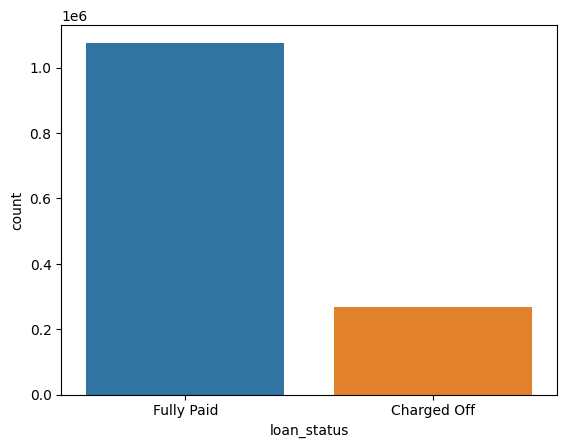

In [8]:
sns.countplot(x= accepted_loans['loan_status'])

In [9]:
num_fully_paid_loans = accepted_loans[accepted_loans['loan_status'] == 'Fully Paid'].shape[0]
num_charged_off_loans = accepted_loans[accepted_loans['loan_status'] == 'Charged Off'].shape[0]
print(num_fully_paid_loans)
print(num_charged_off_loans)
print(num_fully_paid_loans / num_charged_off_loans)

1076751
268559
4.009364795072964


# Data cleaning

In [10]:
# missing percentage
(accepted_loans.isnull().sum() / len(accepted_loans) * 100).sort_values(ascending=False)

next_pymnt_d                                  100.000000
member_id                                     100.000000
orig_projected_additional_accrued_interest     99.720585
hardship_start_date                            99.572292
hardship_length                                99.572292
                                                 ...    
pub_rec                                         0.000000
open_acc                                        0.000000
fico_range_high                                 0.000000
fico_range_low                                  0.000000
id                                              0.000000
Length: 151, dtype: float64

In [11]:
# dropping columns have more than 50% missing data
keeping_columns = accepted_loans.columns[accepted_loans.isnull().sum() < (len(accepted_loans) / 2)].to_list()
len(keeping_columns)

93

In [12]:
accepted_loans = accepted_loans[keeping_columns]
(accepted_loans.isnull().sum() / len(accepted_loans) * 100).sort_values(ascending=False).head(50)

mths_since_recent_inq         12.939100
num_tl_120dpd_2m               8.726688
mo_sin_old_il_acct             7.847634
emp_title                      6.376597
emp_length                     5.835904
pct_tl_nvr_dlq                 5.030885
avg_cur_bal                    5.021073
num_rev_accts                  5.019512
mo_sin_rcnt_rev_tl_op          5.019512
mo_sin_old_rev_tl_op           5.019512
mo_sin_rcnt_tl                 5.019438
num_rev_tl_bal_gt_0            5.019438
num_accts_ever_120_pd          5.019438
num_actv_bc_tl                 5.019438
num_actv_rev_tl                5.019438
num_bc_tl                      5.019438
tot_coll_amt                   5.019438
total_rev_hi_lim               5.019438
num_op_rev_tl                  5.019438
num_il_tl                      5.019438
tot_cur_bal                    5.019438
tot_hi_cred_lim                5.019438
num_tl_op_past_12m             5.019438
total_il_high_credit_limit     5.019438
num_tl_30dpd                   5.019438


In [13]:
# dropping up to 'title' feature
dropping_columns = accepted_loans.isnull().sum().sort_values(ascending=False).head(37).index
accepted_loans = accepted_loans.drop(columns=dropping_columns)
accepted_loans.shape

(1345310, 56)

In [14]:
(accepted_loans.isnull().sum() / len(accepted_loans) * 100).sort_values(ascending=False)

last_pymnt_d                  0.171931
revol_util                    0.063703
pub_rec_bankruptcies          0.051810
dti                           0.027800
chargeoff_within_12_mths      0.004163
collections_12_mths_ex_med    0.004163
last_credit_pull_d            0.004088
tax_liens                     0.002899
inq_last_6mths                0.000074
zip_code                      0.000074
delinq_amnt                   0.000000
disbursement_method           0.000000
out_prncp_inv                 0.000000
total_pymnt                   0.000000
total_pymnt_inv               0.000000
total_rec_prncp               0.000000
total_rec_int                 0.000000
total_rec_late_fee            0.000000
recoveries                    0.000000
collection_recovery_fee       0.000000
acc_now_delinq                0.000000
hardship_flag                 0.000000
last_pymnt_amnt               0.000000
initial_list_status           0.000000
last_fico_range_high          0.000000
last_fico_range_low      

In [15]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 56 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1345310 non-null  object 
 1   loan_amnt                   1345310 non-null  float64
 2   funded_amnt                 1345310 non-null  float64
 3   funded_amnt_inv             1345310 non-null  float64
 4   term                        1345310 non-null  object 
 5   int_rate                    1345310 non-null  float64
 6   installment                 1345310 non-null  float64
 7   grade                       1345310 non-null  object 
 8   sub_grade                   1345310 non-null  object 
 9   home_ownership              1345310 non-null  object 
 10  annual_inc                  1345310 non-null  float64
 11  verification_status         1345310 non-null  object 
 12  issue_d                     1345310 non-null  object 
 1

# Preprocessing

<AxesSubplot: xlabel='loan_amnt', ylabel='Count'>

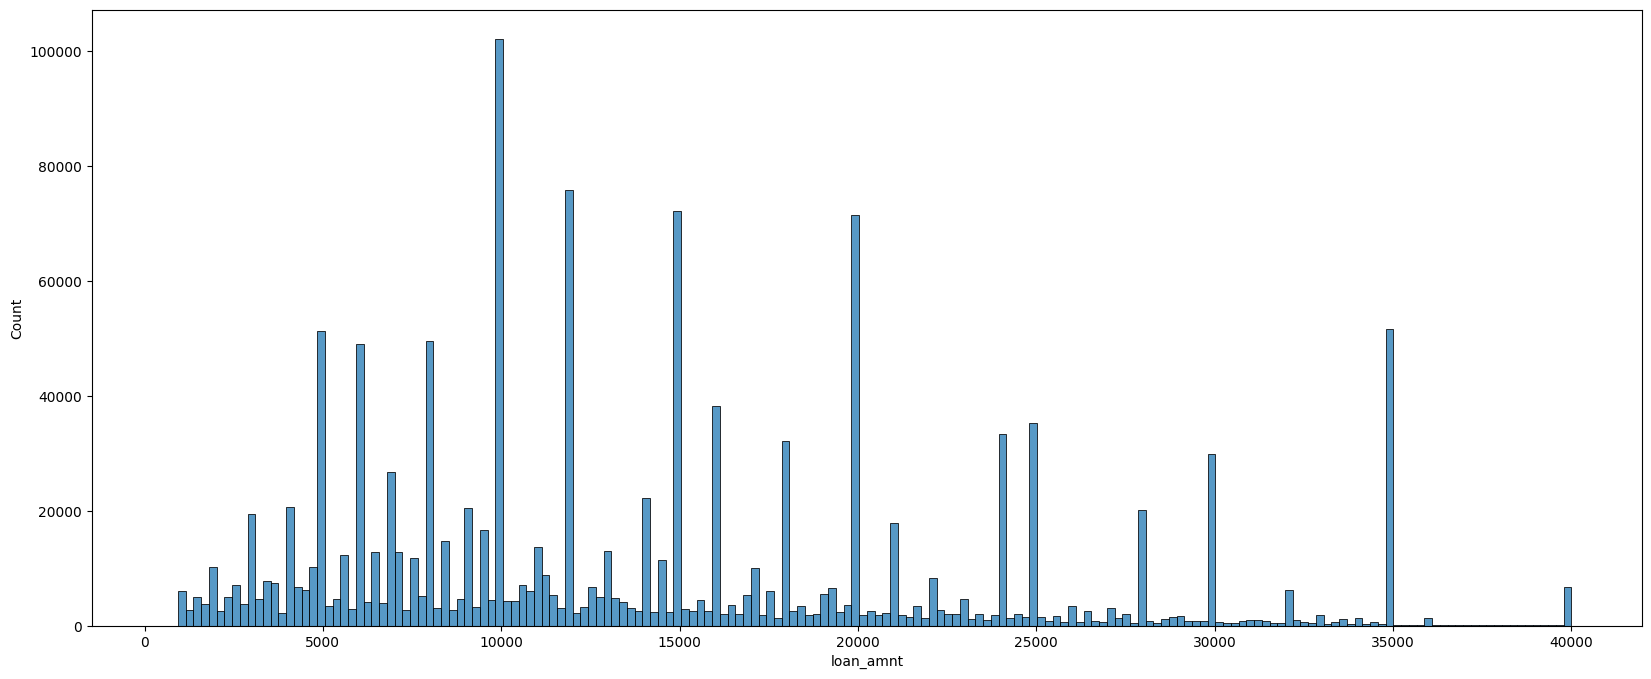

In [16]:
plt.figure(figsize=(20, 8))
sns.histplot(accepted_loans['loan_amnt'])

**Seeing correlation between continuous features via heatmap**

/tmp/ipykernel_20/4175311885.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(accepted_loans.corr())
/tmp/ipykernel_20/4175311885.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(accepted_loans.corr(), mask=mask, cmap='viridis')


<AxesSubplot: >

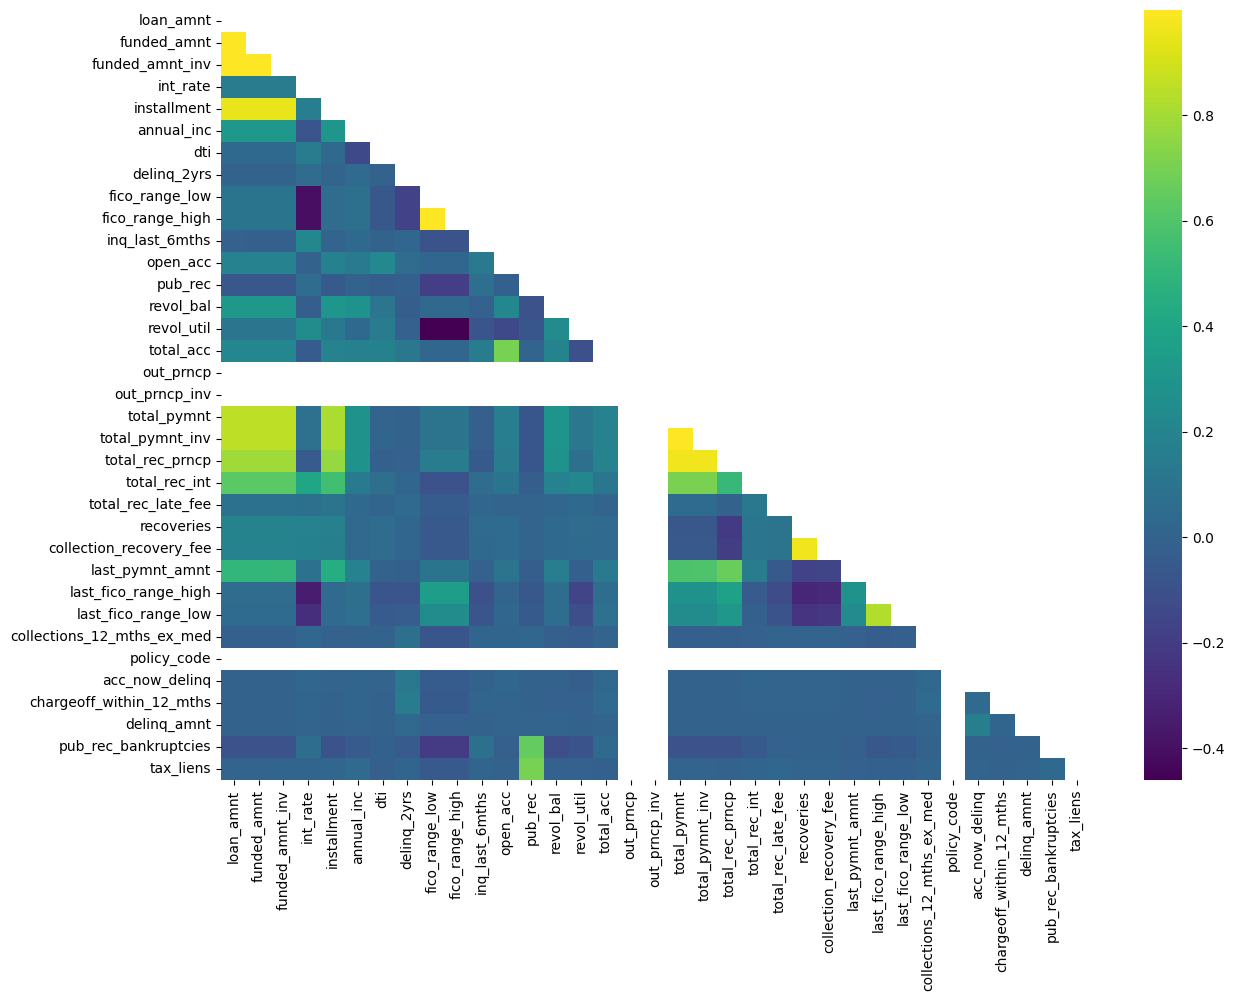

In [17]:
plt.figure(figsize=(14, 10))
mask = np.zeros_like(accepted_loans.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(accepted_loans.corr(), mask=mask, cmap='viridis')

In [18]:
#There are 3 columns with a visible different behaviour: out_prncp, out_prncp_inv and policy_code
print(accepted_loans['out_prncp'].value_counts())
print(accepted_loans['out_prncp_inv'].value_counts())
print(accepted_loans['policy_code'].value_counts())

0.0    1345310
Name: out_prncp, dtype: int64
0.0    1345310
Name: out_prncp_inv, dtype: int64
1.0    1345310
Name: policy_code, dtype: int64


In [19]:
# They are constant, so we can drop these features
dropping_columns =['out_prncp','out_prncp_inv','policy_code']
accepted_loans= accepted_loans.drop(columns = dropping_columns)
accepted_loans.shape

(1345310, 53)

/tmp/ipykernel_20/1486153548.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(accepted_loans.corr())
/tmp/ipykernel_20/1486153548.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(accepted_loans.corr(), mask = mask, cmap='viridis')


<AxesSubplot: >

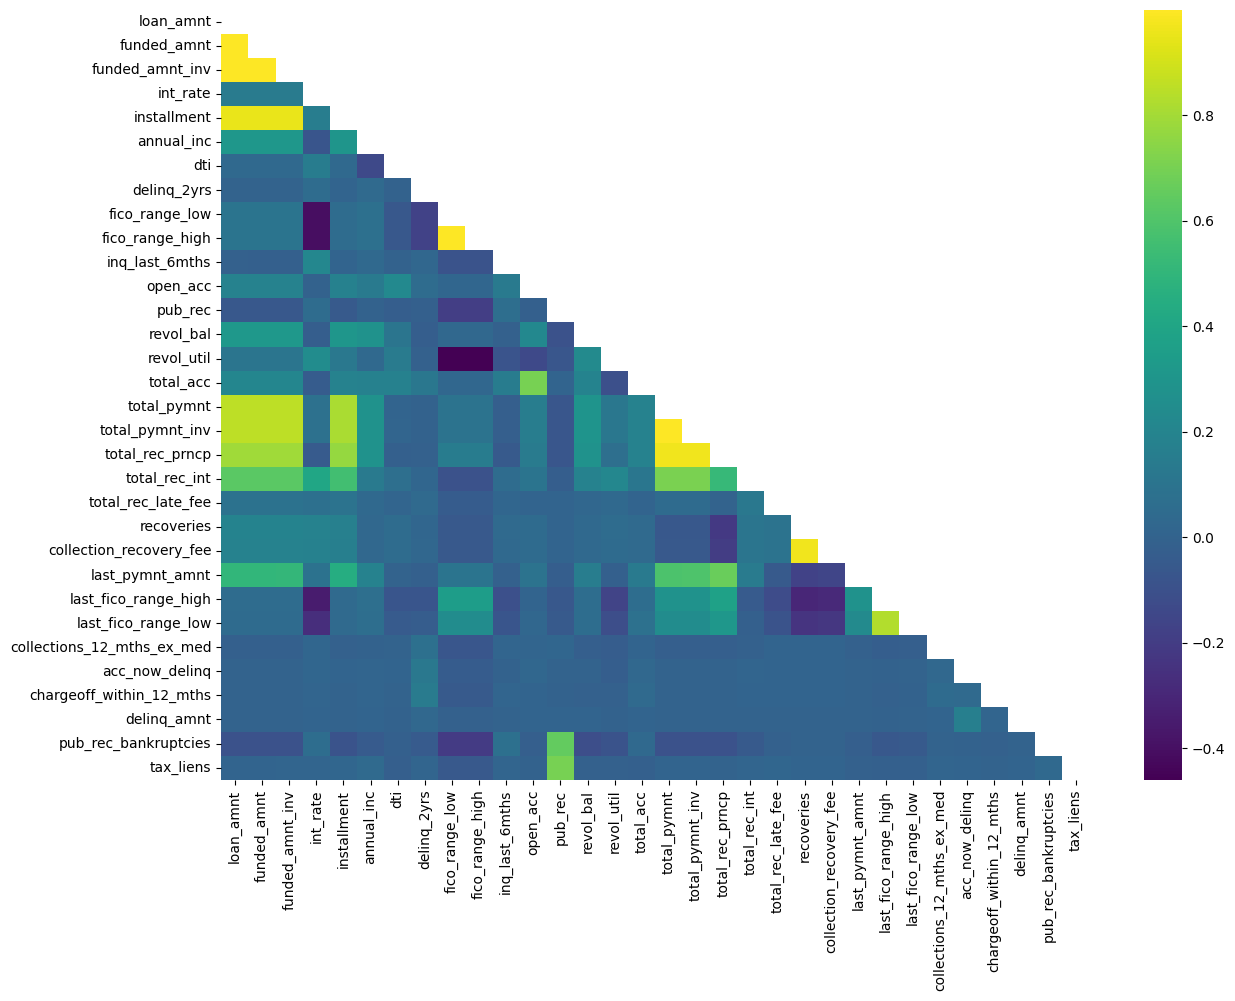

In [20]:
plt.figure(figsize=(14,10))
mask = np.zeros_like(accepted_loans.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(accepted_loans.corr(), mask = mask, cmap='viridis')

# Leakage features

In [21]:
leakage_columns = ['last_pymnt_d', 'last_fico_range_low', 'issue_d', 'funded_amnt_inv', 'funded_amnt', 'last_fico_range_high', 'funded_amnt_inv', 'collection_recovery_fee', 'recoveries', 'total_rec_late_fee', 'total_rec_int', 'total_rec_prncp', 'total_pymnt_inv', 'total_pymnt']
possible_leakage_columns = ['last_credit_pull_d', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']

In [22]:
accepted_loans = accepted_loans.drop(columns=leakage_columns)

In [23]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 40 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1345310 non-null  object 
 1   loan_amnt                   1345310 non-null  float64
 2   term                        1345310 non-null  object 
 3   int_rate                    1345310 non-null  float64
 4   installment                 1345310 non-null  float64
 5   grade                       1345310 non-null  object 
 6   sub_grade                   1345310 non-null  object 
 7   home_ownership              1345310 non-null  object 
 8   annual_inc                  1345310 non-null  float64
 9   verification_status         1345310 non-null  object 
 10  loan_status                 1345310 non-null  object 
 11  pymnt_plan                  1345310 non-null  object 
 12  url                         1345310 non-null  object 
 1

In [24]:
# Unstacking correlation to see highest correlation pairs
correlation_matrix = accepted_loans.corr().abs()
unstack_corr = correlation_matrix.unstack()
unstack_corr = unstack_corr.sort_values(ascending=False)

corr_df = pd.DataFrame(unstack_corr).drop_duplicates().reset_index()
corr_df.columns = ['feature 1', 'feature 2', 'corr']

# check pairs of feature having corr > 0.8
condition1 = corr_df['corr'] > 0.8
condition2 = corr_df['feature 1'] != corr_df['feature 2']
corr_df[condition1 & condition2]


/tmp/ipykernel_20/1051829662.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = accepted_loans.corr().abs()


,feature 1,feature 2,corr
1,fico_range_high,fico_range_low,1.000000
2,installment,loan_amnt,0.953401


**Performing scatter plot to check some correlations between variables**

<AxesSubplot: xlabel='fico_range_low', ylabel='fico_range_high'>

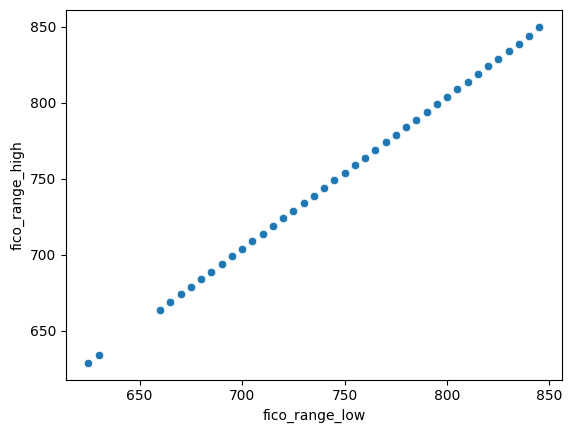

In [25]:
sns.scatterplot(x= accepted_loans['fico_range_low'],y =accepted_loans['fico_range_high'])

<AxesSubplot: xlabel='loan_amnt', ylabel='installment'>

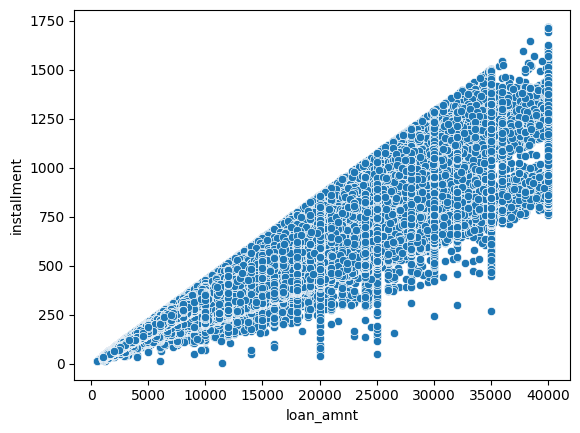

In [26]:
sns.scatterplot(x= accepted_loans['loan_amnt'],y =accepted_loans['installment'])

In [27]:
accepted_loans.drop('fico_range_low', inplace=True, axis=1)

In [28]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 39 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1345310 non-null  object 
 1   loan_amnt                   1345310 non-null  float64
 2   term                        1345310 non-null  object 
 3   int_rate                    1345310 non-null  float64
 4   installment                 1345310 non-null  float64
 5   grade                       1345310 non-null  object 
 6   sub_grade                   1345310 non-null  object 
 7   home_ownership              1345310 non-null  object 
 8   annual_inc                  1345310 non-null  float64
 9   verification_status         1345310 non-null  object 
 10  loan_status                 1345310 non-null  object 
 11  pymnt_plan                  1345310 non-null  object 
 12  url                         1345310 non-null  object 
 1

# Creating a new feature - loan_paid - that is 1 for 'Fully Paid' and 0 for 'Charged Off'

In [29]:
accepted_loans['loan_paid'] = accepted_loans['loan_status'].replace({'Fully Paid': 1, 'Charged Off':0})
accepted_loans = accepted_loans.drop(columns =['loan_status'])

# Working on categorical features

In [30]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 39 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1345310 non-null  object 
 1   loan_amnt                   1345310 non-null  float64
 2   term                        1345310 non-null  object 
 3   int_rate                    1345310 non-null  float64
 4   installment                 1345310 non-null  float64
 5   grade                       1345310 non-null  object 
 6   sub_grade                   1345310 non-null  object 
 7   home_ownership              1345310 non-null  object 
 8   annual_inc                  1345310 non-null  float64
 9   verification_status         1345310 non-null  object 
 10  pymnt_plan                  1345310 non-null  object 
 11  url                         1345310 non-null  object 
 12  purpose                     1345310 non-null  object 
 1

In [31]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))
accepted_loans[categorical_columns]

Index(['id', 'term', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'pymnt_plan', 'url', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_credit_pull_d', 'application_type', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
18


,id,term,grade,sub_grade,home_ownership,verification_status,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,C4,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,PA,Aug-2003,w,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,C1,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,SD,Dec-1999,w,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,B4,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,IL,Aug-2000,w,Mar-2019,Joint App,N,Cash,N
4,68476807,60 months,F,F1,MORTGAGE,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,PA,Jun-1998,w,Mar-2018,Individual,N,Cash,N
5,68426831,36 months,C,C3,RENT,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,300xx,GA,Oct-1987,w,May-2017,Individual,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,60 months,B,B2,OWN,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,775xx,TX,Jul-2004,f,Mar-2019,Individual,N,Cash,N
2260690,88948836,60 months,C,C3,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,900xx,CA,Mar-2002,f,Jul-2018,Individual,N,Cash,N
2260691,89996426,60 months,C,C4,MORTGAGE,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,863xx,AZ,Jun-2011,f,Dec-2018,Individual,N,Cash,N
2260692,90006534,60 months,C,C1,RENT,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,medical,284xx,NC,Aug-1997,f,Mar-2019,Individual,N,Cash,N


In [32]:
print(accepted_loans['pymnt_plan'].value_counts())
print(accepted_loans['hardship_flag'].value_counts())

n    1345310
Name: pymnt_plan, dtype: int64
N    1345310
Name: hardship_flag, dtype: int64


In [33]:
# Dropping features 'id', 'pymnt_plan' and 'hardship_flag' (constant features)
dropping_columns =['id', 'pymnt_plan', 'hardship_flag']
accepted_loans = accepted_loans.drop(columns = dropping_columns)
accepted_loans.shape

(1345310, 36)

In [34]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))
accepted_loans[categorical_columns]

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'url', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
15


,term,grade,sub_grade,home_ownership,verification_status,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_credit_pull_d,application_type,disbursement_method,debt_settlement_flag
0,36 months,C,C4,MORTGAGE,Not Verified,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,PA,Aug-2003,w,Mar-2019,Individual,Cash,N
1,36 months,C,C1,MORTGAGE,Not Verified,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,SD,Dec-1999,w,Mar-2019,Individual,Cash,N
2,60 months,B,B4,MORTGAGE,Not Verified,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,IL,Aug-2000,w,Mar-2019,Joint App,Cash,N
4,60 months,F,F1,MORTGAGE,Source Verified,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,PA,Jun-1998,w,Mar-2018,Individual,Cash,N
5,36 months,C,C3,RENT,Source Verified,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,300xx,GA,Oct-1987,w,May-2017,Individual,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,60 months,B,B2,OWN,Not Verified,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,775xx,TX,Jul-2004,f,Mar-2019,Individual,Cash,N
2260690,60 months,C,C3,MORTGAGE,Not Verified,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,900xx,CA,Mar-2002,f,Jul-2018,Individual,Cash,N
2260691,60 months,C,C4,MORTGAGE,Source Verified,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,863xx,AZ,Jun-2011,f,Dec-2018,Individual,Cash,N
2260692,60 months,C,C1,RENT,Not Verified,https://lendingclub.com/browse/loanDetail.acti...,medical,284xx,NC,Aug-1997,f,Mar-2019,Individual,Cash,N


**Feature 'term'**

In [35]:
print(accepted_loans['term'].value_counts())

 36 months    1020743
 60 months     324567
Name: term, dtype: int64


In [36]:
# convert 'term' into either a 36 or 60 integer numeric data type
accepted_loans['term'] = accepted_loans['term'].str.strip().replace({'36 months': 36, '60 months': 60}) 
accepted_loans['term']

0          36
1          36
2          60
4          60
5          36
           ..
2260688    60
2260690    60
2260691    60
2260692    60
2260697    60
Name: term, Length: 1345310, dtype: int64

In [37]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['grade', 'sub_grade', 'home_ownership', 'verification_status', 'url',
       'purpose', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
14


**Features "grade" and "sub_grade"**

In [38]:
print(accepted_loans['grade'].value_counts())

B    392741
C    381686
A    235090
D    200953
E     93650
F     32058
G      9132
Name: grade, dtype: int64


In [39]:
print(accepted_loans['sub_grade'].value_counts())

C1    85494
B4    83199
B5    82538
B3    81827
C2    79213
C3    74998
C4    74421
B2    74024
B1    71153
C5    67560
A5    64003
A4    52235
D1    51321
D2    44848
A1    43678
D3    39317
A3    37996
A2    37178
D4    35566
D5    29901
E1    23749
E2    21377
E3    18387
E4    15720
E5    14417
F1     9970
F2     7198
F3     6088
F4     4859
F5     3943
G1     2997
G2     2131
G3     1614
G4     1280
G5     1110
Name: sub_grade, dtype: int64


<AxesSubplot: xlabel='grade', ylabel='count'>

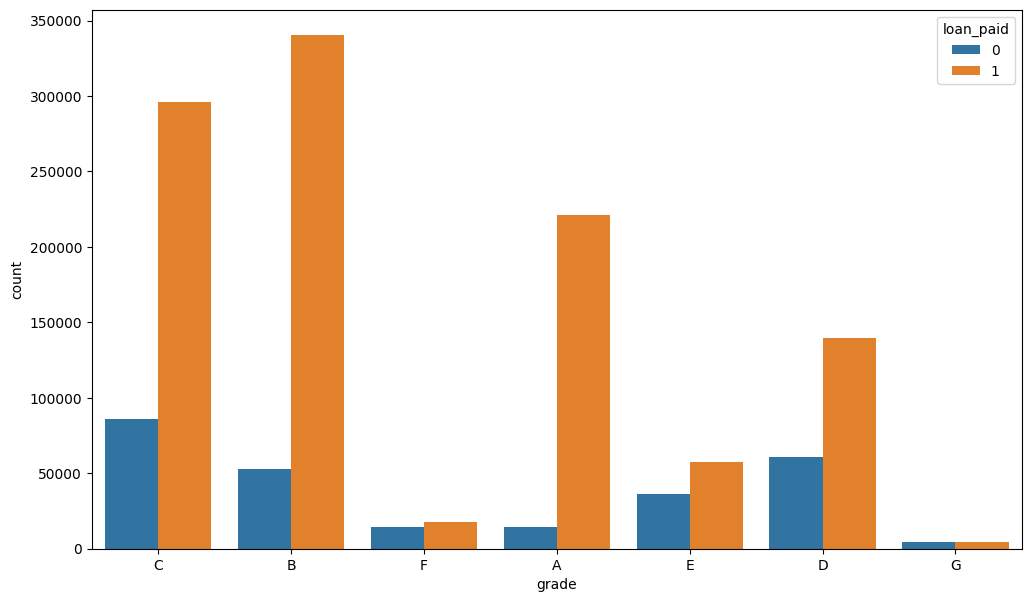

In [40]:
# checking count per grade and loan_paid
plt.figure(figsize=(12,7))
sns.countplot(x= accepted_loans['grade'], hue=accepted_loans['loan_paid'])

<AxesSubplot: xlabel='sub_grade', ylabel='count'>

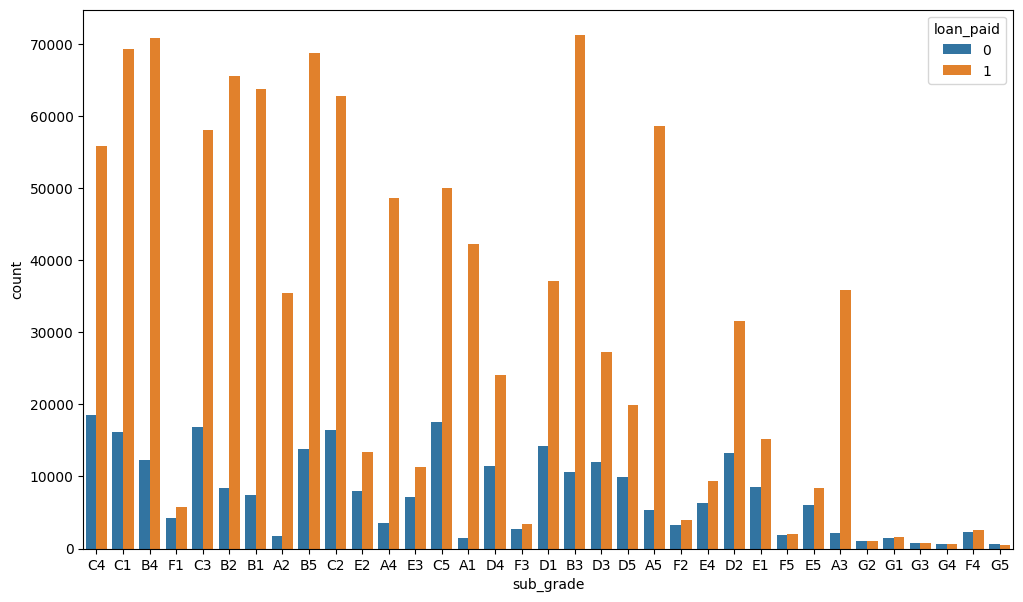

In [41]:
# checking count per subgrade and loan_paid
plt.figure(figsize=(12,7))
sns.countplot(x=accepted_loans['sub_grade'], hue = accepted_loans['loan_paid'])

In [42]:
# Since grade is part of sub_grade, so let's just drop the grade feature
accepted_loans = accepted_loans.drop(columns ='grade')

In [43]:
accepted_loans = pd.get_dummies(accepted_loans, columns=['sub_grade'], prefix='sub_grade', prefix_sep='_', drop_first=True)

In [44]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['home_ownership', 'verification_status', 'url', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
12


**Features 'verification_status', 'purpose', 'application_type', 'initial_list_status' and 'home_ownership'**

In [45]:
#For these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.
dummies =['verification_status', 'purpose', 'application_type', 'initial_list_status','home_ownership']
for dummy_var in dummies:
    print(accepted_loans[dummy_var].unique())

['Not Verified' 'Source Verified' 'Verified']
['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']
['Individual' 'Joint App']
['w' 'f']
['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE' 'OTHER']


In [46]:
for dummy_var in dummies:
  accepted_loans = pd.get_dummies(accepted_loans, prefix=dummy_var, columns=[dummy_var], drop_first=True)

In [47]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['url', 'zip_code', 'addr_state', 'earliest_cr_line',
       'last_credit_pull_d', 'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
7


**Features 'url', 'last_credit_pull_d' and 'earliest_cr_line'**

In [48]:
print(accepted_loans['url'].value_counts())

https://lendingclub.com/browse/loanDetail.action?loan_id=68407277     1
https://lendingclub.com/browse/loanDetail.action?loan_id=143395570    1
https://lendingclub.com/browse/loanDetail.action?loan_id=143480412    1
https://lendingclub.com/browse/loanDetail.action?loan_id=142972000    1
https://lendingclub.com/browse/loanDetail.action?loan_id=143487081    1
                                                                     ..
https://lendingclub.com/browse/loanDetail.action?loan_id=83114087     1
https://lendingclub.com/browse/loanDetail.action?loan_id=83162263     1
https://lendingclub.com/browse/loanDetail.action?loan_id=81940285     1
https://lendingclub.com/browse/loanDetail.action?loan_id=82020283     1
https://lendingclub.com/browse/loanDetail.action?loan_id=88224441     1
Name: url, Length: 1345310, dtype: int64


In [49]:
print(accepted_loans['last_credit_pull_d'].value_counts())

Mar-2019    470827
Feb-2019     74850
Jan-2019     61319
Jul-2018     53543
Oct-2016     50653
             ...  
May-2007         1
Jun-2008         1
Jul-2008         1
Dec-2007         1
Apr-2019         1
Name: last_credit_pull_d, Length: 140, dtype: int64


In [50]:
print(len(accepted_loans['earliest_cr_line'].unique()))

739


In [51]:
# Drop these features
dropping_columns = ['url', 'last_credit_pull_d', 'earliest_cr_line']
accepted_loans = accepted_loans.drop(columns= dropping_columns)

In [52]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['zip_code', 'addr_state', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
4


# Features 'disbursement_method' and 'debt_settlement_flag'

<AxesSubplot: xlabel='debt_settlement_flag', ylabel='count'>

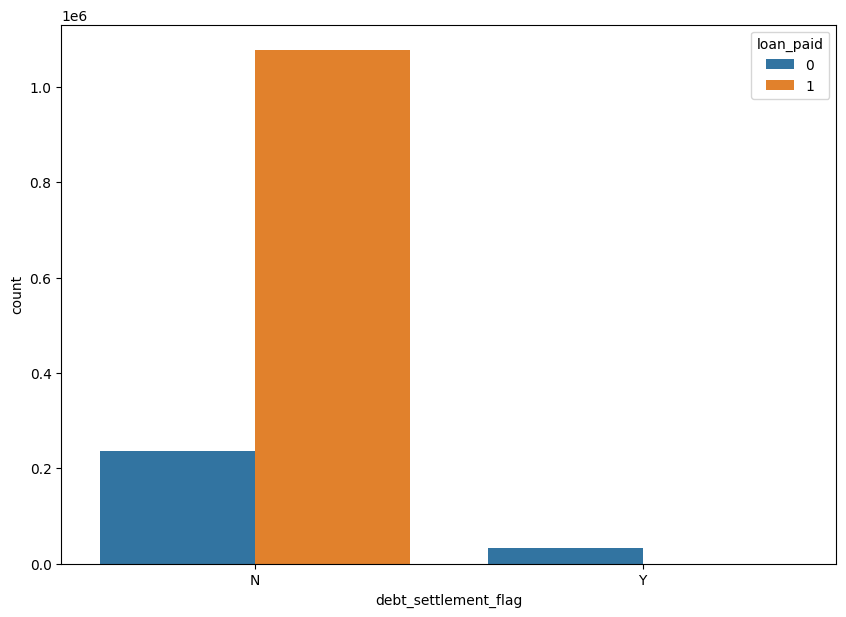

In [53]:
plt.figure(figsize=(10, 7))
sns.countplot(x=accepted_loans['debt_settlement_flag'], hue=accepted_loans['loan_paid'])

<AxesSubplot: xlabel='disbursement_method', ylabel='count'>

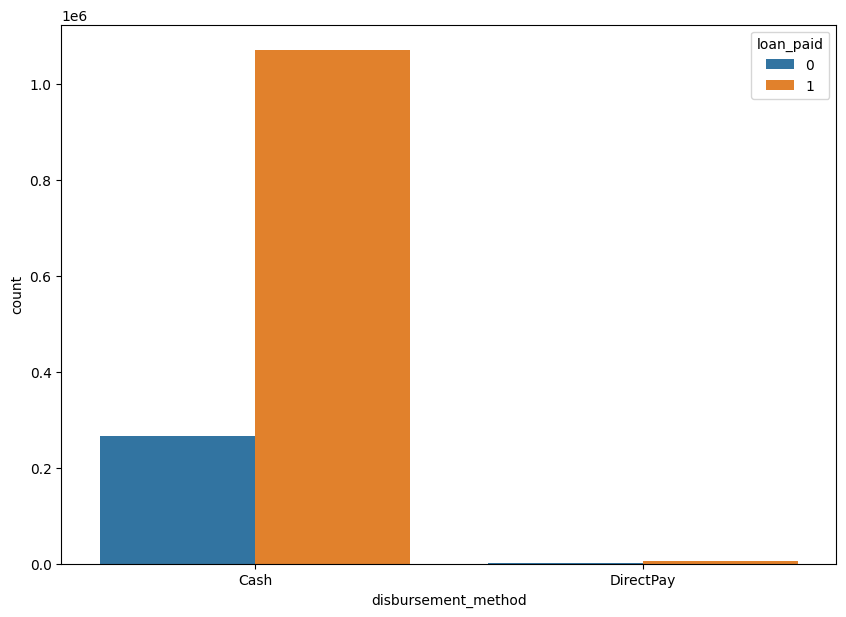

In [54]:
plt.figure(figsize=(10, 7))
sns.countplot(x=accepted_loans['disbursement_method'], hue=accepted_loans['loan_paid'])

In [55]:
print(accepted_loans['disbursement_method'].value_counts())
print(accepted_loans['debt_settlement_flag'].value_counts())

Cash         1338410
DirectPay       6900
Name: disbursement_method, dtype: int64
N    1312034
Y      33276
Name: debt_settlement_flag, dtype: int64


It seem that these features can cause data leakage, let's drop these features first

In [56]:
dropping_columns = ['disbursement_method', 'debt_settlement_flag']
accepted_loans = accepted_loans.drop(columns=dropping_columns)

In [57]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['zip_code', 'addr_state'], dtype='object')
2


**Features 'zip_code' and 'addr_state'**

In [58]:
print(accepted_loans['zip_code'].value_counts())

945xx    15005
750xx    14474
112xx    13829
606xx    12433
300xx    12124
         ...  
095xx        1
009xx        1
872xx        1
513xx        1
525xx        1
Name: zip_code, Length: 943, dtype: int64


In [59]:
# Drop 'zip_code' feature
accepted_loans = accepted_loans.drop(columns=['zip_code'])

In [60]:
print(accepted_loans['addr_state'].unique())
print(len(accepted_loans['addr_state'].unique()))

['PA' 'SD' 'IL' 'GA' 'MN' 'SC' 'RI' 'NC' 'CA' 'VA' 'AZ' 'IN' 'MD' 'NY'
 'TX' 'KS' 'NM' 'AL' 'WA' 'OH' 'LA' 'FL' 'CO' 'MI' 'MO' 'DC' 'MA' 'WI'
 'HI' 'VT' 'NJ' 'DE' 'TN' 'NH' 'NE' 'OR' 'CT' 'AR' 'NV' 'WV' 'MT' 'WY'
 'OK' 'KY' 'MS' 'UT' 'ND' 'ME' 'AK' 'ID' 'IA']
51


In [61]:
# Drop 'addr_state' feature
accepted_loans.drop('addr_state', inplace=True, axis=1)

In [62]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index([], dtype='object')
0


In [63]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 78 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1345310 non-null  float64
 1   term                                 1345310 non-null  int64  
 2   int_rate                             1345310 non-null  float64
 3   installment                          1345310 non-null  float64
 4   annual_inc                           1345310 non-null  float64
 5   dti                                  1344936 non-null  float64
 6   delinq_2yrs                          1345310 non-null  float64
 7   fico_range_high                      1345310 non-null  float64
 8   inq_last_6mths                       1345309 non-null  float64
 9   open_acc                             1345310 non-null  float64
 10  pub_rec                              1345310 non-null  float64
 11

# Handling missing data

In [64]:
(accepted_loans.isnull().sum() / len(accepted_loans) * 100).sort_values(ascending=False).head(20)

revol_util                             0.063703
pub_rec_bankruptcies                   0.051810
dti                                    0.027800
chargeoff_within_12_mths               0.004163
collections_12_mths_ex_med             0.004163
tax_liens                              0.002899
inq_last_6mths                         0.000074
sub_grade_G3                           0.000000
purpose_credit_card                    0.000000
verification_status_Verified           0.000000
verification_status_Source Verified    0.000000
sub_grade_G5                           0.000000
sub_grade_G4                           0.000000
loan_amnt                              0.000000
purpose_educational                    0.000000
sub_grade_G2                           0.000000
sub_grade_G1                           0.000000
sub_grade_F5                           0.000000
sub_grade_F4                           0.000000
sub_grade_F3                           0.000000
dtype: float64

In [65]:
#There are 7 features having missing values but all of them account for less than 0.1% -> Let's drop any rows with missing values
accepted_loans = accepted_loans.dropna()

# Save data

In [66]:
accepted_loans.to_csv('/kaggle/working/elite_data.csv', index=False)